In [12]:
%load_ext rpy2.ipython
from common import *

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [13]:
%%R
if(getwd()!='/home/wdeng3/workspace/Codespace/scRTE/scripts'){
    setwd('/home/wdeng3/workspace/Codespace/scRTE/scripts')
}
source('common.r')

In [18]:
%%R
library(Seurat)
library(stringr)
cell_type_map<-list('Excitatory'='Ex','Inhibitory'='In','OPC'='OPC','Oligodendrocyte'='Oli','Microglia'='Mic','Endothelial'='Endo','Astrocyte'='Ast','VLMC/Per'='VLMC')
for(dataset in c('AD_HS_00001_Intron','AD_HS_00002_Intron')){
    seurat_obj<-readRDS(paste0('../data/seurat_objs/',dataset,'.rds'))
    exp_mtx<-as.data.frame(t(as.data.frame(GetAssayData(seurat_obj,slot = 'data'))))
    exp_mtx$UMAP_1<-seurat_obj@reductions[['umap']]@cell.embeddings[,1]
    exp_mtx$UMAP_2<-seurat_obj@reductions[['umap']]@cell.embeddings[,2]
    write.table(exp_mtx,paste0('../data/all_datasets/',dataset,'.cell_exp.txt'),row.names = T,quote = F,sep = '\t',col.names = T)

    cell_meta<-NULL
    seurat_obj@meta.data$UMAP_1<-seurat_obj@reductions[['umap']]@cell.embeddings[,1]
    seurat_obj@meta.data$UMAP_2<-seurat_obj@reductions[['umap']]@cell.embeddings[,2]
    seurat_obj@meta.data$dataset<-dataset
    seurat_obj@meta.data$stage<-'N/A'
    # seurat_obj@meta.data[seurat_obj@meta.data$predicted.celltype=='Opc','predicted.celltype']<-'OPC'
    if (!('msex' %in% colnames(seurat_obj@meta.data))){
        seurat_obj@meta.data$msex<-'N/A'
    }
    if (!('age_death' %in% colnames(seurat_obj@meta.data))){
        seurat_obj@meta.data$age_death<-'N/A'
    }
    if(is.null(cell_meta)){
        cell_meta<-seurat_obj@meta.data[,c('major.cell.type.prediction.seaad','Diagnosis','stage','msex','age_death','UMAP_1','UMAP_2','dataset')]
    }else{
        cell_meta<-rbind(cell_meta,seurat_obj@meta.data[,c('major.cell.type.prediction.seaad','Diagnosis','stage','msex','age_death','UMAP_1','UMAP_2','dataset')])
    }
    cell_meta["Stage" %in% cell_meta$Diagnosis,'Diagnosis']<-'AD'
    cell_meta["control" %in% cell_meta$Diagnosis,'Diagnosis']<-'Control'
    # cell_meta[cell_meta$predicted.celltype=='Opc','predicted.celltype']<-'OPC'
    cell_meta$predicted.celltype<-unlist(lapply(cell_meta$major.cell.type.prediction.seaad,function(x) cell_type_map[[x]]))
    write.table(cell_meta,paste0('../data/all_datasets/',dataset,'.cell_umap.txt'),row.names = ,quote = F,sep = '\t',col.names = T)
}

In [21]:
## time comsuming, memory comsuming
pool=Pool(2)
datasets=[x.replace('.cell_exp.txt','') for x in ['AD_HS_00001_Intron.cell_exp.txt','AD_HS_00001.cell_exp.txt',
                                                  'AD_HS_00002_Intron.cell_exp.txt','AD_HS_00002.cell_exp.txt']]
results=pool.map(get_dataset_nomerge,datasets)                                                                                                                                                                    
pool.close()
pool.join()
all_dfs={}
all_cell_umaps={}
for ret in results: 
    df,dataset,cell_umap=ret
    cell_umaps=df.iloc[:,-2:]
    df=np.expm1(df.iloc[:,:-2])
    df=pd.concat([df,cell_umaps],axis=1)
    all_dfs[dataset]=df.copy()
    all_cell_umaps[dataset]=cell_umap.copy()

results=None

loading data: AD_HS_00001_Intron 
loading data: AD_HS_00001 


Done loading: AD_HS_00001_Intron 

loading data: AD_HS_00002_Intron 

Done loading: AD_HS_00001 

loading data: AD_HS_00002 

Done loading: AD_HS_00002_Intron 

Done loading: AD_HS_00002 



In [22]:
max_exp=None
region_count=defaultdict(lambda:defaultdict(int))
rtes=rmsk['repName'].unique()
cell_umaps={}
for dataset in datasets:
    print(dataset)
    df=all_dfs[dataset]
    df=pd.DataFrame(df,index=df.index,columns=df.columns)
    df.fillna(0,inplace=True)
    sum_=df.sum(axis=0).to_list()
    for i in range(len(df.columns)-2):
        gene=df.columns[i]
        if gene in gene_type:
            region_count[dataset][gene_type[gene]]+=sum_[i]
            
    drtes=df.loc[:,[x for x in df.columns if x in rtes]]
    mean_=drtes.mean(axis=0).to_list()
    poce=[np.count_nonzero(drtes.iloc[:,i]>1)/(1.0*len(drtes.index)) for i in range(len(drtes.columns))]

    tmp=pd.DataFrame([mean_,poce,[dataset]*len(drtes.columns),drtes.columns,[te_cls[x] for x in drtes.columns]],columns=drtes.columns,index=['Mean','PoE','Dataset','RTE','RTE_Fam']).transpose()

    tmp.sort_values(by='Mean',inplace=True,ascending=False)
    for fam in ['SINE','LINE','LTR']:
        if max_exp is None:
            max_exp=tmp.loc[tmp.RTE_Fam==fam,:]#.head(n=10)
        else:
            max_exp=pd.concat([max_exp,tmp.loc[tmp.RTE_Fam==fam,:]],ignore_index=True)
max_exp.sort_values(by=['Dataset','RTE_Fam','Mean'],ascending=False,inplace=True)
max_exp['Mean']=np.log1p(list(max_exp['Mean']))
max_exp.to_csv('../data/analysis/max_exp_intron.txt',header=True,index=False,sep='\t')

AD_HS_00001_Intron
AD_HS_00001
AD_HS_00002_Intron
AD_HS_00002


In [25]:
count_df=pd.DataFrame(dict(region_count))
count_df=count_df[['AD_HS_00001','AD_HS_00002','AD_HS_00001_Intron','AD_HS_00002_Intron']]
count_df=count_df.loc[['LINE','SINE','LTR'],:]

for dataset in count_df.columns:
    count_df[dataset]=count_df[dataset]/count_df[dataset].sum()
    
## read#, rte, dataset
ret=[]
for i in range(len(count_df)):
    for j in range(len(count_df.columns)):
        ret.append([count_df.iloc[i,j], count_df.index[i], count_df.columns[j]])
ret=pd.DataFrame(ret,columns=['Read#','RTE','Dataset'])
ret=ret.loc[ret['RTE'].isin(['LINE','SINE','LTR']),:]
ret.to_csv('../data/analysis/cls_read_proportion_intron.txt',sep='\t',header=True,index=False)

png 
  2 


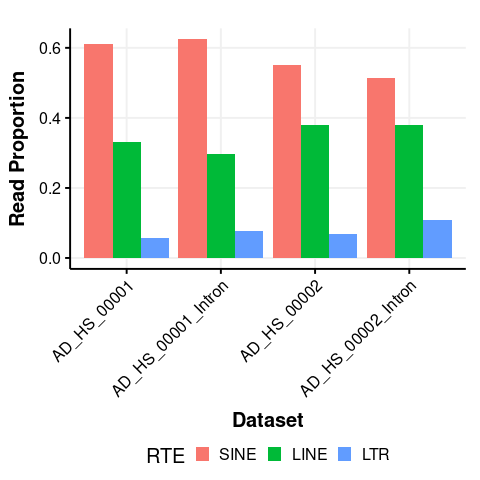

In [27]:
%%R
df<-read.csv('../data/analysis/cls_read_proportion_intron.txt',sep='\t',header=T,)
df$RTE=factor(df$RTE,levels=c('SINE','LINE','LTR'))
p<-ggplot(df,aes(x=Dataset,y=Read.,Group=RTE,fill=RTE))+geom_bar(stat='identity',position='dodge')+labs(x='Dataset',y='Read Proportion')+theme_Publication()+theme(axis.text.x=element_text(angle=45,vjust=1,hjust=1))
print(p)
pdf('../data/analysis/figures/cls_read_proportion_intron.pdf',width=7,height=7)
print(p)
dev.off()

In [28]:
cells=['Ast','Ex','In','Oli','OPC','Endo','Mic','VLMC']
table=[]
for dataset in all_dfs.keys():
    print(dataset,end=',')
    umap=all_cell_umaps[dataset]
    tmp=[]
    for cell in cells:
        tmp.append(len(umap.loc[umap['predicted.celltype']==cell,:]))
    tmp.append(len(umap))
    table.append(tmp)
table=pd.DataFrame(table,index=all_dfs.keys())
table.columns=cells+['Total']
table

AD_HS_00001_Intron,AD_HS_00001,AD_HS_00002_Intron,AD_HS_00002,

,Ast,Ex,In,Oli,OPC,Endo,Mic,VLMC,Total
AD_HS_00001_Intron,1948,7826,2237,10054,1561,86,740,23,24475
AD_HS_00001,1606,14963,3167,13056,1399,300,992,360,35843
AD_HS_00002_Intron,1685,5101,2610,6371,775,29,524,215,17310
AD_HS_00002,1668,6080,3264,6542,866,144,643,210,19417


png 
  2 


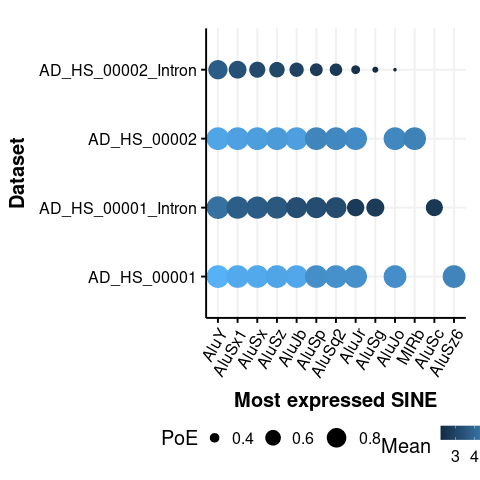

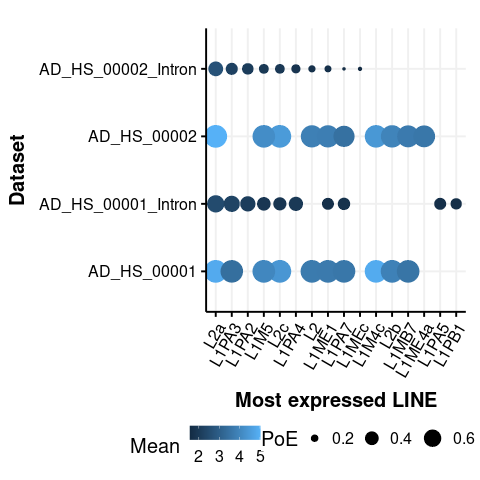

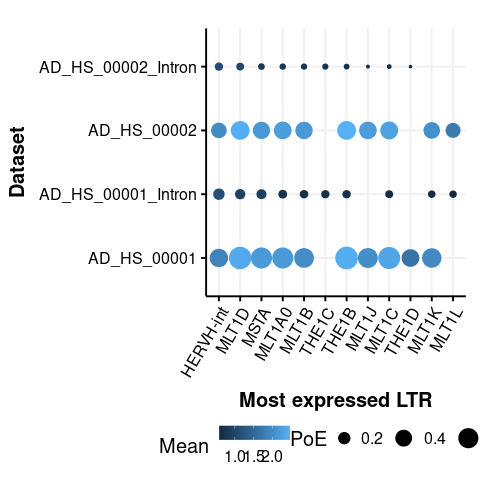

In [30]:
%%R
most_exp<-read.csv("../data/analysis/max_exp_intron.txt",sep='\t')
ps<-list()

for(cls in c('SINE','LINE','LTR')){
    df<-NULL
    sine_exp<-most_exp[most_exp$RTE_Fam==cls,]
    for(dataset in unique(sine_exp$Dataset)){
        tmp<-sine_exp[sine_exp$Dataset==dataset,]
        tmp<-tmp[1:10,]
        if(is.null(df)){
            df<-tmp
        }else{
            df<-rbind(df,tmp)
        }
    }
    df<-as.data.frame(df,colnames=colnames(sine_exp))
    df$RTE<-factor(df$RTE,levels=unique(df$RTE))
    p<-ggplot(df,aes(x=RTE,y=Dataset,size=PoE,color=Mean))+geom_point()+theme_Publication()+
        scale_size(range = c(1, 10))+theme(axis.text.x = element_text(angle = 60, hjust = 1))+xlab(paste0('Most expressed ',cls))
    ps[[length(ps)+1]]<-p
    print(p)
}
pdf("../data/analysis/figures/most_exp_intron.pdf",width=7,height=7)
for(p in ps){
    plot(p)
}
dev.off()